This notebook accomplishes the following goals:

1. Creates a scustomer scoring based on customer behaviour (recency and frequency) and employs kmeans++
2. Creates a data class to load and manipulate the last.fm dataset
3. Loads and transforms last.fm data and generates scores for the users based on their listening habit to music

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
np.random.seed(42)

### Download data from last.fm

In [2]:
#! wget http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-1K.tar.gz

### unpack a tar.gz file

In [1]:
#!tar -xzvf lastfm-dataset-1K.tar.gz

In [2]:
class Data:
    def __init__(self):
        """initialize the Data Class"""
        self.data = None
        
    def read_file(self, filename, format='tsv', columns = None):
        '''
        The function loads data from excel, csv, tsv, or txt file
        Args:
            filename- the path to the file to be read
            format - the format of the file
        Returns
             - None
        '''
        if format == 'excel':
            self.data = pd.read_excel(filename)
        elif format == 'csv':
            self.data = pd.read_csv(filename)
        elif format == 'tsv':
            self.data = pd.read_csv(filename, sep='\t', names= columns)
        elif format == 'txt':
            self.data = pd.read_table(filename)
        else:
            raise ValueError('Invalid file format.  Please specify "excel", "csv", "tsv", or "txt".')

    
    def drop_cols(self, drop_cols):
        """
        The function updates the data instance by dropping unwanted columns
        Args:
            drop_cols- list type item; columns to be dropped
        
        Returns:
            a downsized dataframe
        """
       
        self.data = self.data.drop(drop_cols, axis = 1)
        return self.data
    
    def add_extra_columns(self, userid, column1, column2):
        """
        Generate new features named recency and frequency from the specified columns
        recency - it is the last time the user was active on the website substracted from the latest date
        frequency - define how ofetn a user interact with the website
        Args:
            userid - type string, column containing userid
            column1 and column2 are string type columns to calculate recency and frequency from respectively
        
        Returns
            a dataframe with two newly generated features
           
        """
        df = self.drop_cols(drop_cols = drop_cols)
        print(df.head())
        print(" ")
        
        # Set Latest date to the last listen habit. This is to calculate the number of days from recent activity
        latest_date = pd.to_datetime("2009/05/05").tz_localize('UTC')
        
        # filter out column with timestamp later than May 5th 2009        
        df = df[(df[column1] <= '2009-05-05')]
        
        # convert column to date and time
        df[column1] = pd.to_datetime(df[column1])
        
        # Create RF Modelling scores for each user
        df = df.groupby(userid).agg({column1: lambda x: (latest_date - x.max()).days, column2: lambda x: len(x)})
        
        #Convert date and time column into type int
        df['timestamp'] = df['timestamp'].astype(int)
                
        #Rename column names to Recency, Frequency
        df.rename(columns={column1: 'recency', 
                         column2: 'frequency'},
                  inplace=True)
        print("\n",df.head(),"\n")
        return df.reset_index()

In [3]:
class Create_Score:
    def __init__(self, df):
        '''initialize Create_Score class'''
        self.df = df
        
    def elbow_method_plot(self, col_plot):
        """
        This function takes a column from the RFM dataframe as a string
        and plots number of k versus sum od squared distances known as
        elbow method to determine the optimum value of k
        Args:
            df - dataframe containing recency and frequency columns
            col_plot - type-list; columns to finds the number of clusters for
        Returns:
            None
        """
        for col in col_plot:
            sum_of_sq_dist = {}
            for k in range(1,15):
                km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
                km = km.fit(self.df[col].values.reshape(-1,1))
                sum_of_sq_dist[k] = km.inertia_  
            # Plot the graph for the sum of square distance values and Number of Clusters
            sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
            plt.xlabel("Number of Clusters (k)")
            plt.ylabel("Sum of Square Distances")
            plt.title("Optimal k for " + col + " using elbow method")
            plt.show()
    
    def score_df(self, rec_cluster_no, freq_cluster_no, rec_col, freq_col):
        """"
        This function generates clusters for specified columns (recency and frequency)
        and generate a score for the users
        Args:
            rec_cluster_no - type- int, optimum no of cluster derived from the elbow plot for the recency column
            freq_cluster_no - type- int, optimum no of cluster derived from the elbow plot for the frequency column
            rec_col -  type - string, recency
            freq_col- type - string, frequency
            
        
        """
    
        ## instantiate kmeans++ with optimum k for recency
        km = KMeans(n_clusters = rec_cluster_no, init= 'k-means++', max_iter= 1000)
        km.fit(self.df[rec_col].values.reshape(-1,1))
        
        # Assigning cluster prediction to customers
        df.loc[:, rec_col +"_cluster"] = km.predict(self.df[[rec_col]])
    
        ## initialize kmeans++ with optimum k for frequency
        km = KMeans(n_clusters = freq_cluster_no, init= 'k-means++', max_iter= 1000)
        km.fit(self.df[freq_col].values.reshape(-1,1))
        
        # Assigning cluster prediction to customers
        df.loc[:, freq_col +"_cluster"] = km.predict(df[[freq_col]])
        
        # Generate score 
        df["score"] = df[[rec_col +"_cluster", freq_col +"_cluster"]].sum(axis = 1)
                
        return df

In [8]:
load_and_process_data = True
create_score = True

## Load tsv file into DataFrame and process data

In [9]:
# Define required variables
filename = "lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv"
columns = ["userid", "timestamp", "musicbrainz-artist-id", "artist-name", "musicbrainz-track-id", "track-name"]
drop_cols = ["artist-name", "musicbrainz-track-id", "track-name"]
userid = "userid"
column1 = "timestamp"
column2 = "musicbrainz-artist-id"

if load_and_process_data:
    data = Data()
    data.read_file(filename, format='tsv', columns = columns)
    df = data.add_extra_columns(userid, column1, column2)

        userid             timestamp                 musicbrainz-artist-id
0  user_000001  2009-05-04T23:08:57Z  f1b1cf71-bd35-4e99-8624-24a6e15f133a
1  user_000001  2009-05-04T13:54:10Z  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8
2  user_000001  2009-05-04T13:52:04Z  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8
3  user_000001  2009-05-04T13:42:52Z  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8
4  user_000001  2009-05-04T13:42:11Z  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8
 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



              recency  frequency
userid                         
user_000001        0      16685
user_000002        6      57438
user_000003        0      19494
user_000004        4      18411
user_000005        0      20341 



## Create an instance for the class create score and make make elbow plots

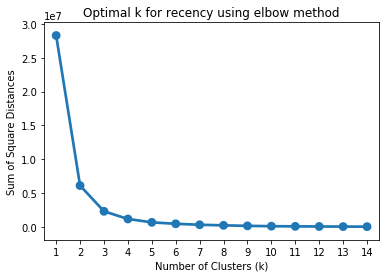

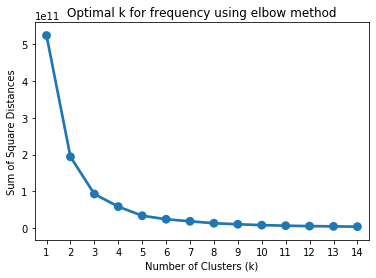

In [11]:
col_plot = ["recency", "frequency"]
if create_score:
    score_df = Create_Score(df)
    score_df.elbow_method_plot(col_plot)

## Create a DataFrame with users scores

In [12]:
rec_cluster_no = 3
freq_cluster_no = 4
rec_col = "recency"
freq_col = "frequency"
score_df = score_df.score_df(rec_cluster_no, freq_cluster_no, rec_col, freq_col)

In [13]:
score_df.head()

,userid,recency,frequency,recency_cluster,frequency_cluster,score
0,user_000001,0,16685,0,0,0
1,user_000002,6,57438,0,2,2
2,user_000003,0,19494,0,0,0
3,user_000004,4,18411,0,0,0
4,user_000005,0,20341,0,0,0


In [14]:
score_df["score"].describe()

count    991.000000
mean       2.083754
std        1.427029
min        0.000000
25%        0.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: score, dtype: float64

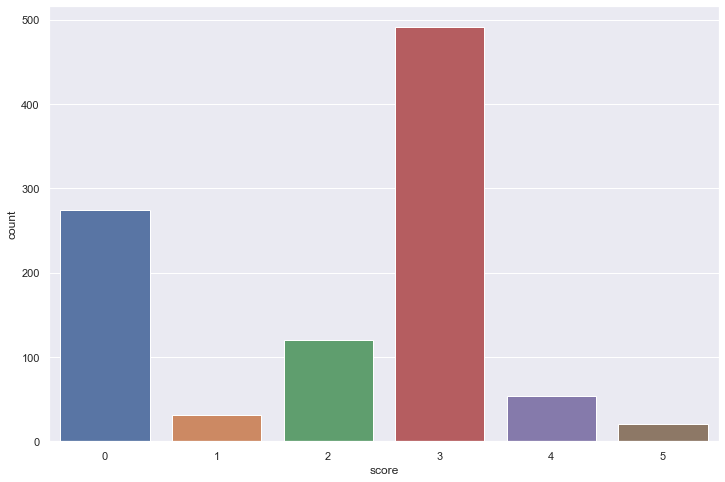

In [18]:
plt.figure(figsize=(12,8))
sns.set(style="darkgrid")
sns.countplot(score_df["score"]);

### A brief summary about the score
- The score ranges between 0 and 5
- The lower the score the more active the users are in terms of recency and how frequent they listen to music on the site
- Based on the score one can categorise the users into active users (0-1), medium users(2-3) and less active users (4-5)
- Most users can be termed medium users with score of 3 while reasonable amount of users are also active users.

### Explain the approach you took

### The approach include:
1. Understand the problems which in this case involves scoring the customers based on the data provided
2. Understanding the data: explore the data
  - Understanding the different type of features
  - The number of samples
  - Check for missing values
  - Check if the data can address the problem
3. A simple scoring method was developed using RF model which is quite similar to RFM (Recency, frequency and monetary)
  - Recency in a RFM analysis is the time since the customer’s most recent transaction (most businesses use days, but one can use months, weeks or even hours). Here recency was calculated based on the recent number of days a user had listened to a music
  - Frequency is how often a customer has transacted or interacted with a product within a specific time frame? 
  - Monetary this is the maount a customer has spent on a product/brand within a specified time. 
  In the last.fm data, the monetary part of the RFM was not calculated because the data does not include price. Hence, the calculation was restricted to just recency and frequency.
 4. After engineering the recency and frequency features, kmeans algorithm was used to detect the clusters for both recency and frequency individaully and a customer score was generated from the clusters
 
 ### Reason for taking the approach
 There are other ways in which one could have done this, however, the pparoach precented here is:
 1. Simple
 2. Intuitive
 3. Easily interpretable
 
 ### Limitations
 Limitations associated with the approach presented here include:
 1. RFM model does not include the length of relationship with a user
 2. There are other dimensions that could have ehnanced te customer scoring which are missing in the RFM model

### Explain what you would ideally do next, if you were doing this in your job and had the time and resources you needed to do it to your satisfaction.

 Things I could have done next are:
1. Consider other dimensions that could add value to the scoring e.g users subscription period
2. Create additional feature engineering
3. Validate the model and collaborate with other teams (product team) to make sure the model addresses the business objectives